In [1]:
import numpy as np

## Here are the functions we need for this

In [2]:
predict = lambda x, w, b: np.matmul(w,x.T) + b
sigmoid = lambda yhat: 1/(1+np.exp(-yhat))
loss = lambda y, sigmoid: -(y*np.log(sigmoid)+(1-y)*np.log(1-sigmoid)).mean()
dldw = lambda x, y, sigmoid: (np.reshape(sigmoid-y,(50,1))*x).mean(axis = 0)
dldb = lambda y, sig: (sig-y).mean(axis = 0)
update = lambda a, g, lr: a-(g*lr)

In [4]:
#b and w are the initial weights all set to 0
def GradDescent(X, y, n_iter, alpha, b = 0, w = None):
    if(w == None):
        w = np.zeros(X.shape[1])
    learning_rate = alpha
    for i in range(n_iter):
        yhat = predict(X,w,b)
        sig = sigmoid(yhat)
        grad_w = dldw(X,y,sig)
        grad_b = dldb(y,sig)
        w = update(w,grad_w,learning_rate)
        b = update(b,grad_b,learning_rate)
    return b,w

To demonstrate this, let's make some random data


In [5]:
from sklearn.datasets import make_classification

In [6]:
clasData = make_classification(n_features = 5, n_samples = 50,random_state = 4)

x=clasData[0]
y=clasData[1]

In [7]:
y

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1])

This gives us dummy classification data with 5 features and 50 in our sample

In [8]:
GradDescent(x, y, 2000, 1)

(-0.728933077054689,
 array([-0.12818396, -0.28864804, -1.11075534,  0.14203945,  2.54489187]))

Compare with LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
model = LogisticRegression()
model.fit(x,y)
print(model.intercept_,model.coef_)

[-0.46372887] [[-0.11404243 -0.19874298 -0.76255719  0.13358927  1.77353138]]


It's not the same :(

In [11]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

Oh LogisticRegression applies l2 regularisation by default, let's see what happens if we remove that

In [12]:
model = LogisticRegression(penalty=None)
model.fit(x,y)
print(model.intercept_,model.coef_)

[-0.72893426] [[-0.1281836  -0.28864813 -1.1107556   0.14204109  2.54489363]]


That's a lot closer!

## Let's do regularisation ourselves

loss and dldw are the things we need to change


In [13]:
lossreg = lambda y, sigmoid, l, w: -(y*np.log(sigmoid)+(1-y)*np.log(1-sigmoid)).mean()+ l/(2*len(y))*(w**2).sum()
dldwreg = lambda x, y, sigmoid, l, w: (np.reshape(sigmoid-y,(50,1))*x).mean(axis = 0) + (l/len(y))*w

In [24]:
def GradDescentwithReg(x, y, n_iter, alpha, b = 0, w = None, l = 1):
    if(w == None):
        w = np.zeros(x.shape[1])
    learning_rate = alpha
    for i in range(n_iter):
        yhat = predict(x,w,b)
        sig = sigmoid(yhat)
        grad_w = dldwreg(x,y,sig, l, w)
        grad_b = dldb(y,sig)
        w = update(w,grad_w,learning_rate)
        b = update(b,grad_b,learning_rate)
    return b,w

In [16]:
GradDescentwithReg(x, y, 1000, 1, l=1)

(-0.46372835335165286,
 array([-0.11404314, -0.19874293, -0.76255704,  0.1335889 ,  1.77353078]))

And that's pretty close to the regularised form from sklearn

## Different amount of regularisation?

In [18]:
GradDescentwithReg(x, y, 1000, 1, l=0.1)

(-0.6804317671624744,
 array([-0.12797542, -0.2718795 , -1.04574135,  0.14158971,  2.40169268]))

In [19]:
model = LogisticRegression(C = 0.1)
model.fit(x,y)
model.intercept_,model.coef_

(array([-0.14111989]),
 array([[-0.06336817, -0.08722793, -0.33349453,  0.0777234 ,  0.78975915]]))

Agh it's different again, why sklearn?

# RTM

C is not the same as $\lambda$, C is actually $\frac{1}{\lambda}$

In [20]:
model = LogisticRegression(C = 1/0.1)
model.fit(x,y)
model.intercept_,model.coef_

(array([-0.68043263]),
 array([[-0.12797468, -0.27187959, -1.04574172,  0.14158944,  2.4016933 ]]))

Phew we're ok!

Always important to read the manual and see what they actually mean about the equivalent variables

In [31]:
def GradDescentwithRegPlot(x, y, n_iter, alpha, b = 0, w = None, l = 1):
    if(w == None):
        w = np.zeros(x.shape[1])
    learning_rate = alpha
    losses = []
    for i in range(n_iter):
        yhat = predict(x,w,b)
        sig = sigmoid(yhat)

        logloss = lossreg(y,sig,l, w)
        losses.append(logloss)
        
        grad_w = dldwreg(x,y,sig, l, w)
        grad_b = dldb(y,sig)
        w = update(w,grad_w,learning_rate)
        b = update(b,grad_b,learning_rate)
    return losses, b, w

In [36]:
losses, _, _ = GradDescentwithRegPlot(x, y, 1000, 0.1, l=0.1)

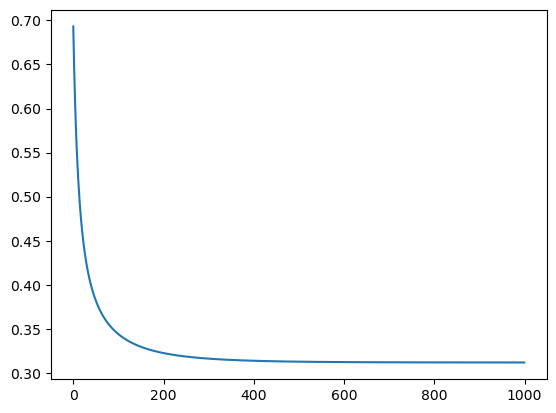

In [37]:
import matplotlib.pyplot as plt
plt.plot(losses)